# Visualizing HSIC Measures

In [2]:
import sys, os
import warnings
import tqdm
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# toy datasets
from data.toy import generate_dependence_data

# Kernel Dependency measure
from models.dependence import HSIC
from models.kernel import estimate_sigma, sigma_to_gamma, gamma_to_sigma, get_param_grid

# RBIG IT measures
from models.ite_algorithms import run_rbig_models

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

In [3]:
fig_path = "/home/emmanuel/projects/2019_hsic_align/results/figures/distribution_experiment/"

In [4]:
save_path   = f'{cwd}/../../results/hsic/'
save_name   = 'dist_v2_median'

cols = [
    'dataset', 
    'trial', 
    'n_samples', 
    'd_dimensions', 
    'nu', 
    'std',
    'gamma', 
    'gamma_init',
    'scorer', 
    'value',
    'mi_score'
]

results_df = pd.read_csv(f"{save_path}{save_name}.csv")[cols]

In [5]:
results_df.tail()

,dataset,trial,n_samples,d_dimensions,nu,std,gamma,gamma_init,scorer,value,mi_score
59995,tstudent,5,5000,100,20.0,NaN,0.588985,scott,tka,1.0000,8.098041
59996,tstudent,5,5000,100,20.0,NaN,0.588985,scott,ctka,1.0000,8.098041
59997,tstudent,5,5000,100,30.0,NaN,0.588985,scott,hsic,0.0002,7.993998
59998,tstudent,5,5000,100,30.0,NaN,0.588985,scott,tka,1.0000,7.993998
59999,tstudent,5,5000,100,30.0,NaN,0.588985,scott,ctka,1.0000,7.993998


In [6]:
res_samples = results_df['n_samples'].unique().tolist()
res_dists = results_df['dataset'].unique().tolist()
res_dimensions = results_df['d_dimensions'].unique().tolist()
res_scorer = results_df['scorer'].unique().tolist()

## Figure I - Gaussian Distribution

In [7]:
results_gaussian = results_df[results_df['dataset'] == 'gauss'].drop(columns=['nu'])

results_gaussian.tail()

,dataset,trial,n_samples,d_dimensions,std,gamma,gamma_init,scorer,value,mi_score
32995,gauss,5,5000,100,0.9,0.921368,scott,tka,1.0000,4.828360
32996,gauss,5,5000,100,0.9,0.921368,scott,ctka,1.0000,4.828360
32997,gauss,5,5000,100,1.0,0.921368,scott,hsic,0.0002,7.938746
32998,gauss,5,5000,100,1.0,0.921368,scott,tka,1.0000,7.938746
32999,gauss,5,5000,100,1.0,0.921368,scott,ctka,1.0000,7.938746


### 1. Take the Mean wrt to the experimental params

In [8]:
def average_trials(res_df):
    # Take the average of the trials
    cols = res_df.columns.tolist()
#     cols.remove('trial')
#     cols.remove('value')
#     cols.remove('gamma')
    return res_df.groupby(cols).mean().drop('trial', axis=1).reset_index()

def variance_trials(res_df):
    # Take the average of the trials
    cols = res_df.columns.tolist()
    cols.remove('trial')
    return res_df.groupby(cols).std().reset_index().drop('trial', axis=1)

### II - Extract the fixed variables with labels

In [9]:
def plot_prepare(res_df, dataset='gauss'):
    
    # grab dataset attributes (fixed variables)
    d_dimensions = res_df['d_dimensions'].unique()
    n_samples = res_df['n_samples'].unique()
    dataset = res_df['dataset'].unique()  
    gamma_init = res_df['gamma_init'].unique()
    scorers = res_df['scorer'].unique().tolist()
    fixed_vars = {
        'd_dimensions':int(d_dimensions),
        'n_samples': int(n_samples),
        'gamma_init': gamma_init,
        'dataset': dataset,
        'scorer': scorers,
    }

    return res_df, fixed_vars

### Step III - Plot

In [10]:
def plot_gammas(res_df, fixed_vars, save=True):
    for iscore in res_df.groupby('scorer'):
        
        if fixed_vars['dataset'][0] == 'gauss':
            param = 'std'
        elif fixed_vars['dataset'][0] == 'tstudent':
            param = 'nu'
        else:
            raise ValueError("Unrecognized dataset:", fixed_vars['dataset'][0])
                             
#         print(iscore[1].head())
        mean_results = iscore[1].groupby(['dataset', 'd_dimensions', 'scorer', param, 'gamma_init']).median()
        std_results = iscore[1].groupby(['dataset', 'd_dimensions', 'scorer', param, 'gamma_init']).std()
        mean_results['hsic_std'] = std_results['value'].values
        mean_results['mi_std'] = std_results['mi_score'].values
        mean_results = mean_results.reset_index().drop(columns=['scorer', 'trial', 'n_samples'])
        gamma_legend = mean_results['gamma_init'].unique()
#         print(mean_results.head(3))
#         break
#         print(mean_results.head())
        fig, ax = plt.subplots()
        pts = sns.scatterplot(
            x='value', 
            y='mi_score', 
            hue='gamma_init',
            data=mean_results, 
#             size='hsic_std',
#             sizes=(50,200),
            legend='brief',
            ax=ax, 
#             hue='gamma', 
#             hue_norm=matplotlib.colors.LogNorm(),
#             label=iscore[0].upper(),
            palette='Spectral'
        )
#         ax.legend(gamma_legend)
        ax.set_xlabel('HSIC Value')
        ax.set_ylabel(r'Mutual Information')
        ax.set_title(
            f"D: {int(fixed_vars['d_dimensions'])},"
            f" N: {fixed_vars['n_samples']},"
            f"{fixed_vars['dataset'][0]}, "
            f"{iscore[0].upper()}"
        )
        
        # COLORBAR
#         norm = matplotlib.colors.LogNorm(mean_results.gamma.min(), mean_results.gamma.max())
#         sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
#         sm.set_array([])
#         pts.figure.colorbar(sm, label=r'RBF Bandwidth, $\gamma$')
        
        plt.show()
        if save:
            save_name = \
                f"{fixed_vars['dataset'][0]}_" + \
                f"{int(fixed_vars['n_samples'])}_" + \
                f"{int(fixed_vars['d_dimensions'])}_" + \
                f"{iscore[0].upper()}" + \
                ".png"

            fig.savefig(fig_path + save_name)
    return None

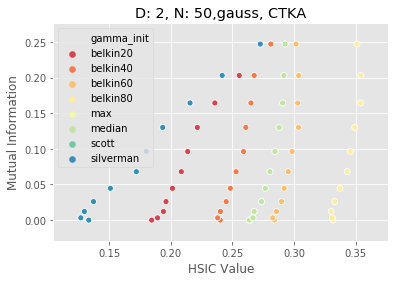

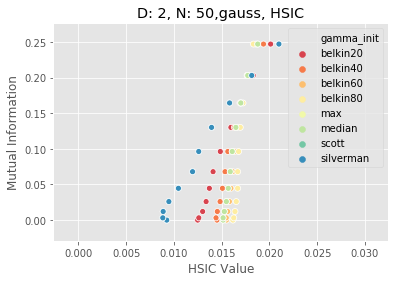

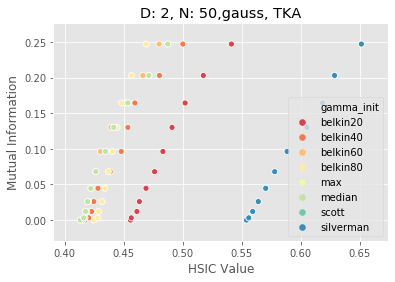

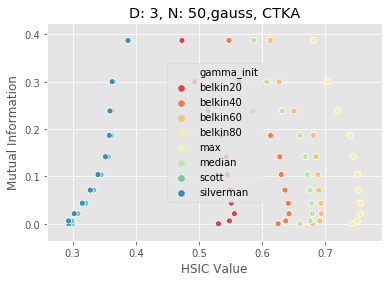

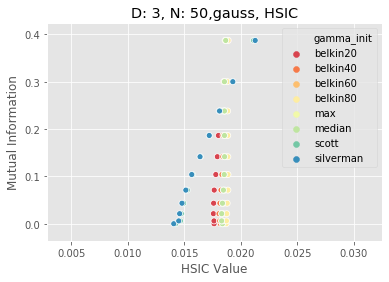

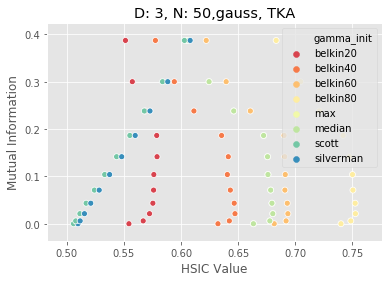

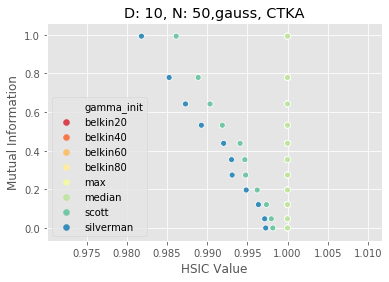

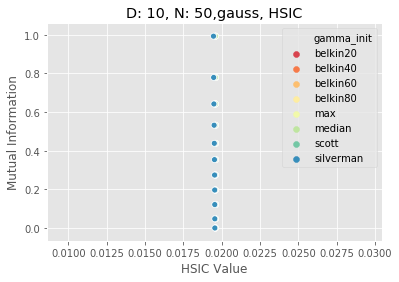

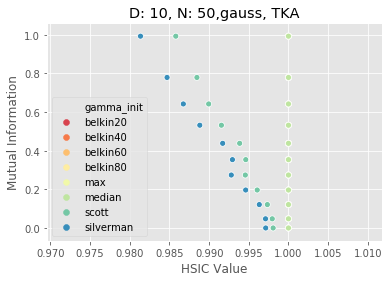

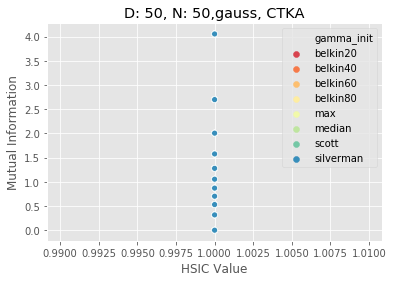

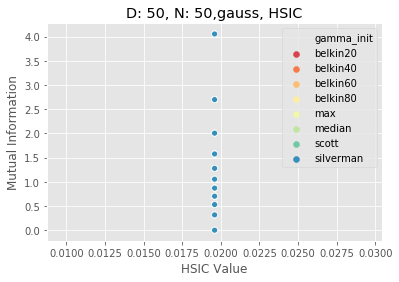

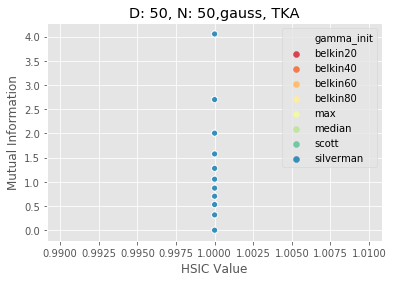

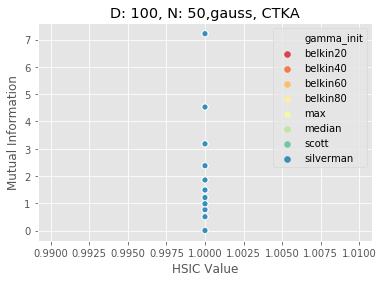

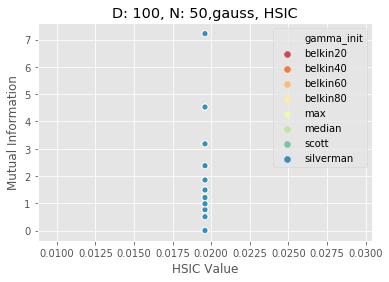

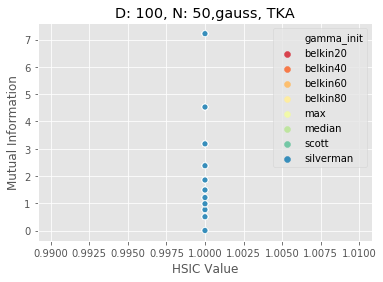

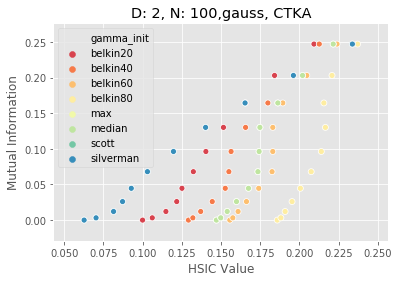

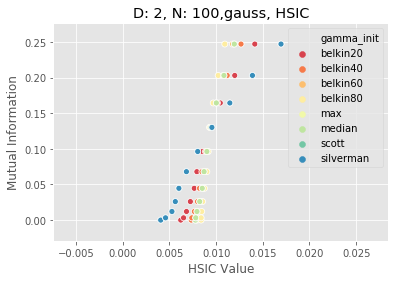

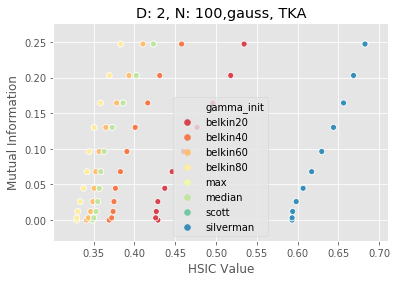

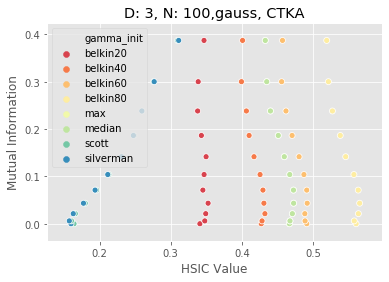

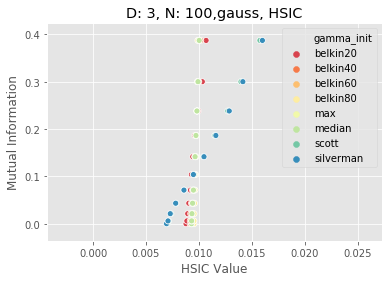

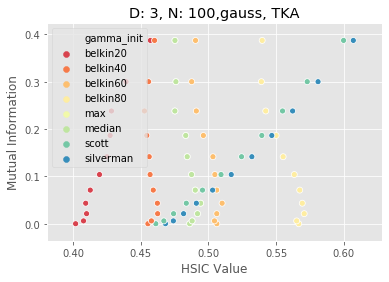

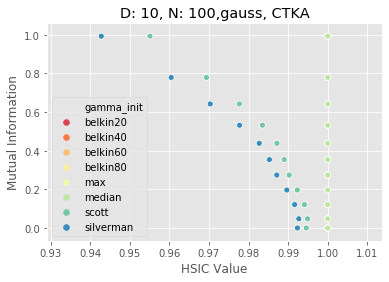

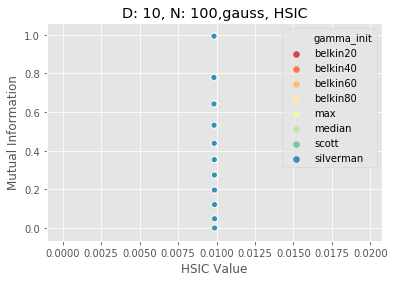

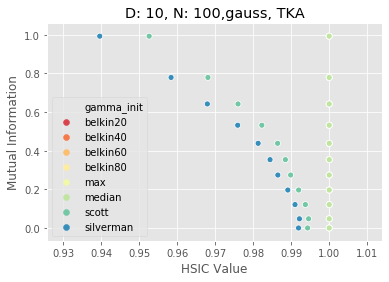

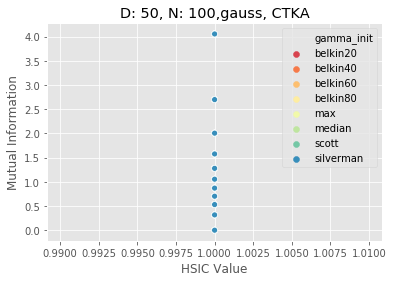

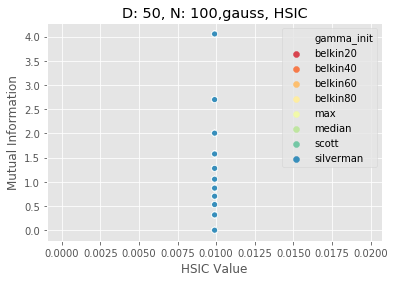

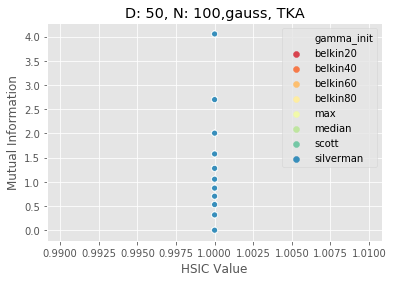

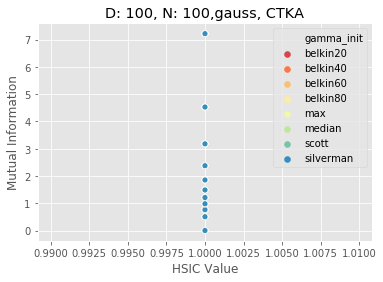

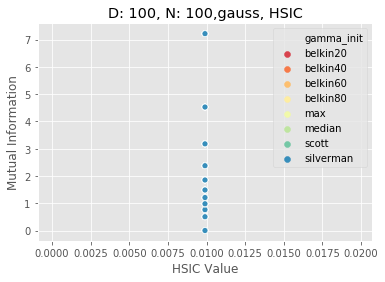

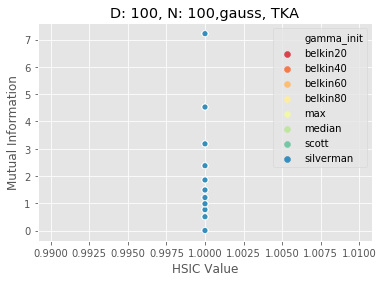

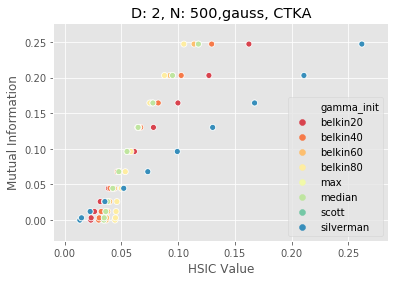

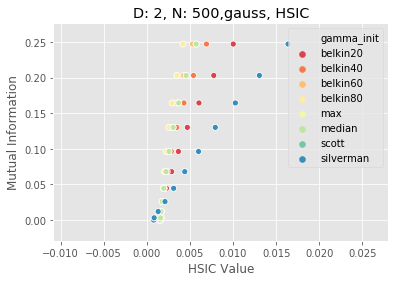

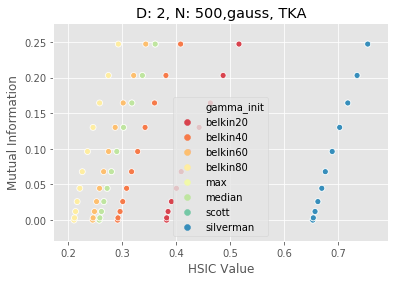

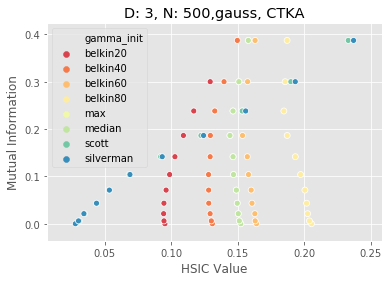

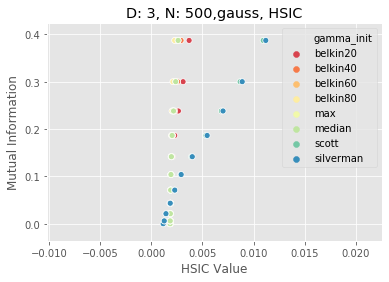

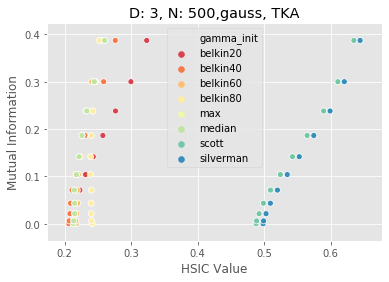

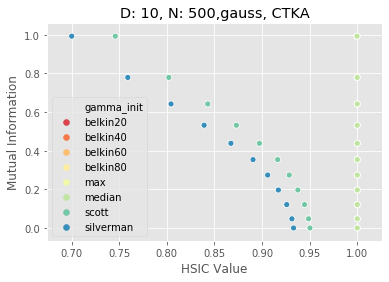

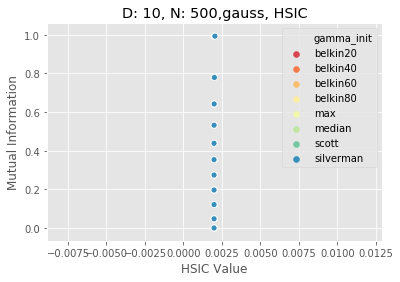

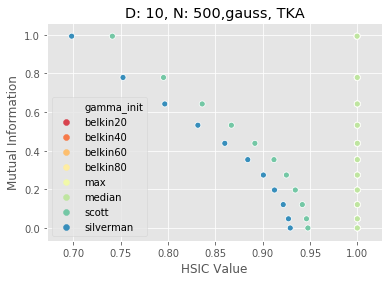

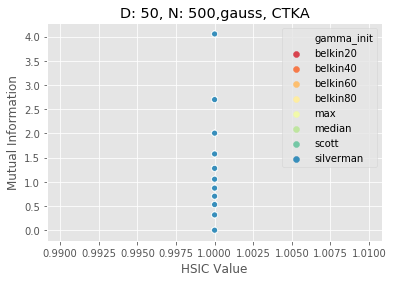

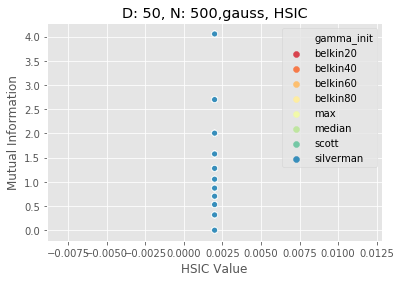

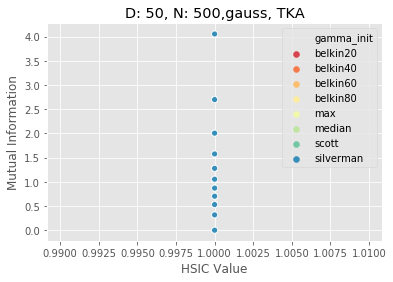

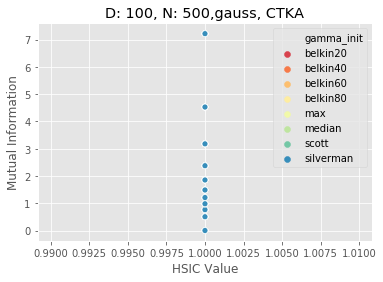

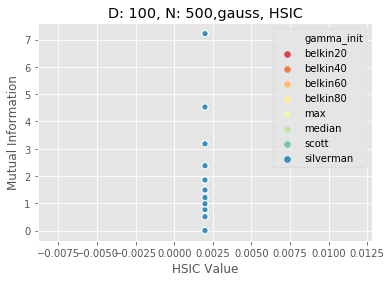

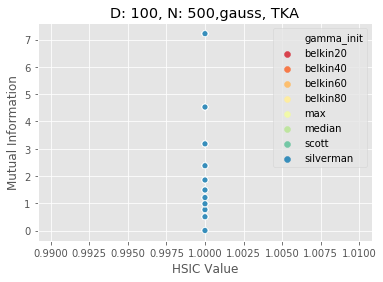

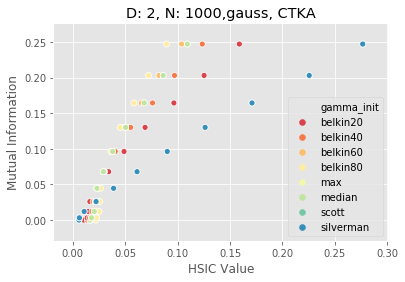

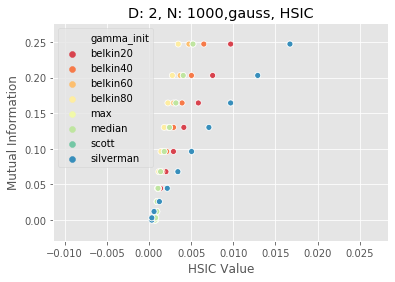

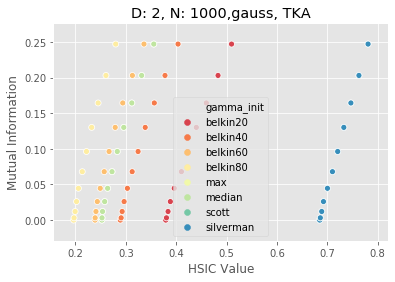

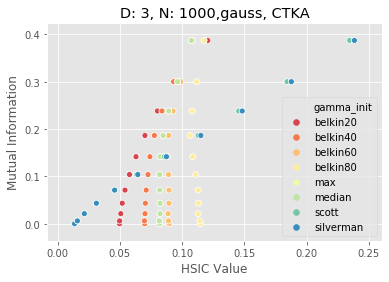

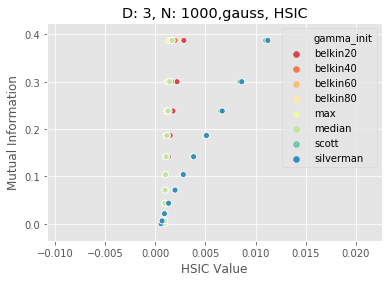

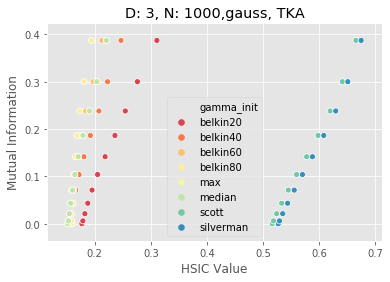

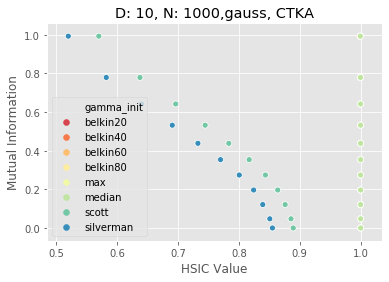

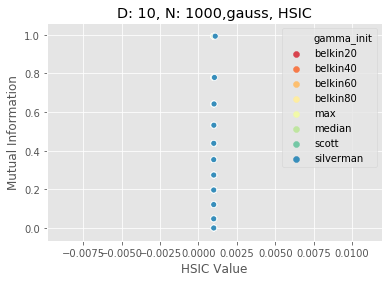

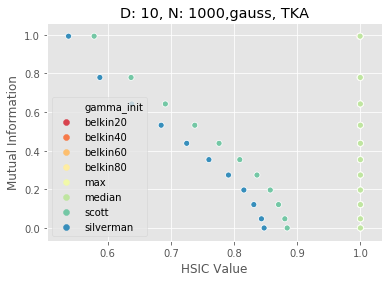

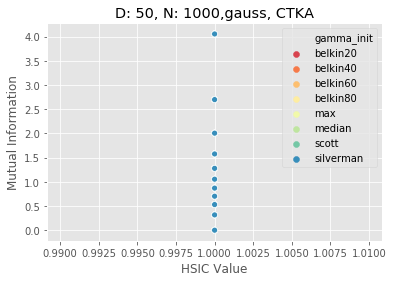

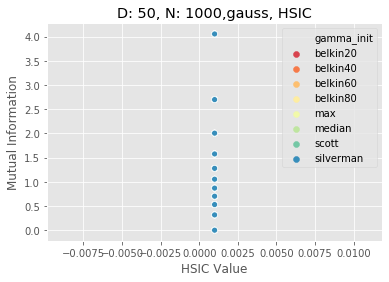

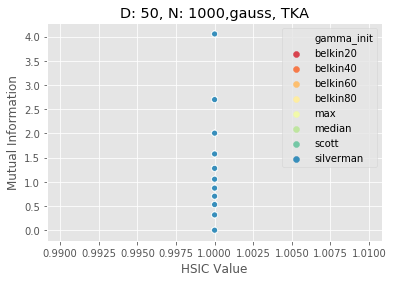

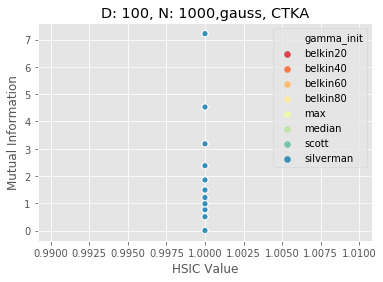

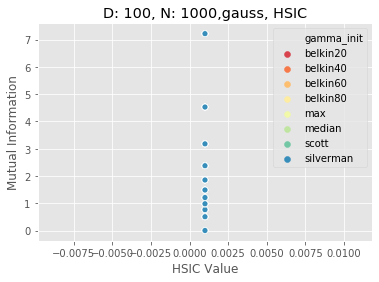

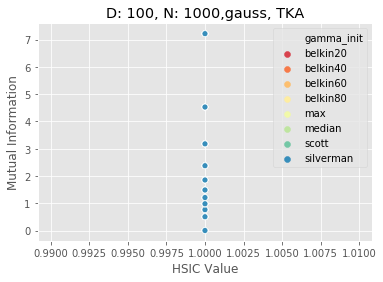

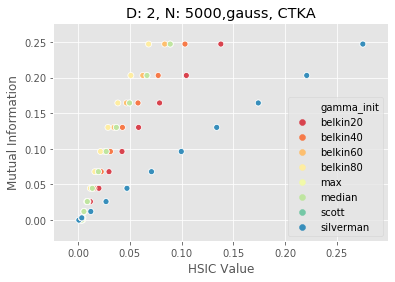

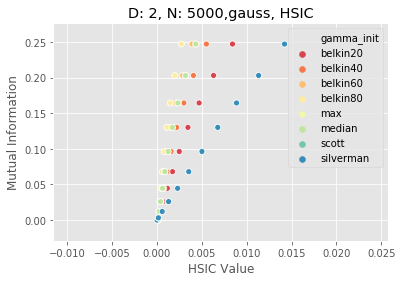

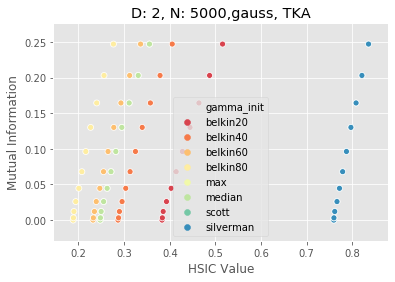

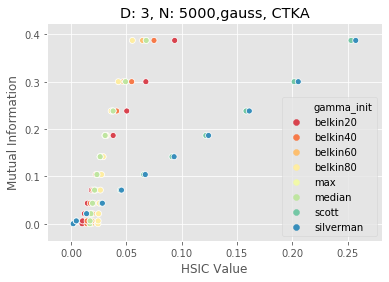

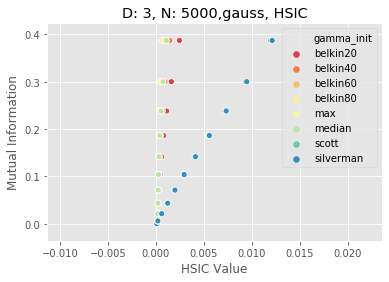

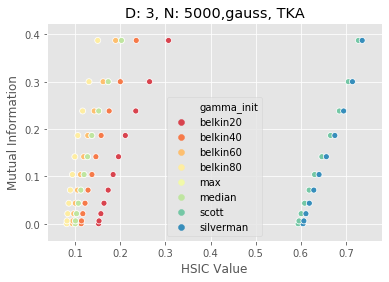

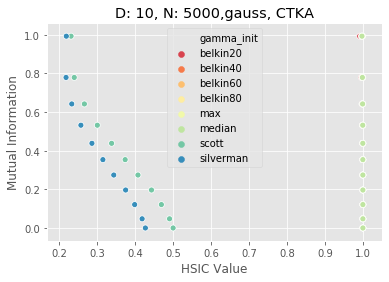

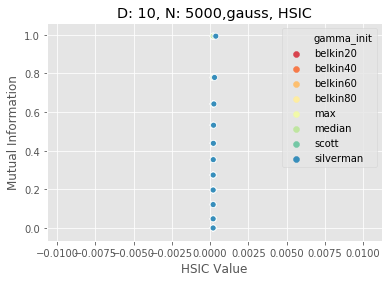

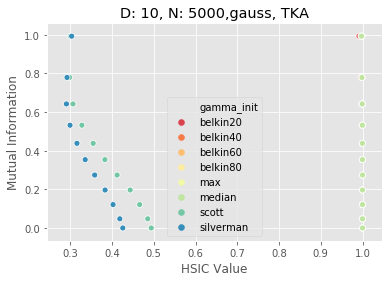

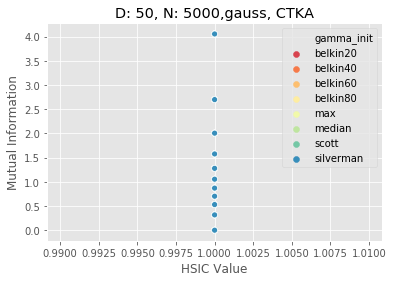

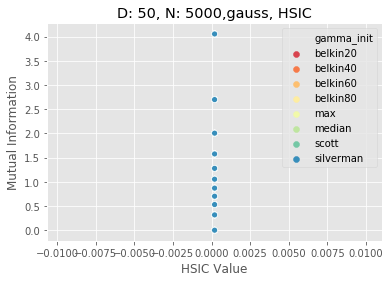

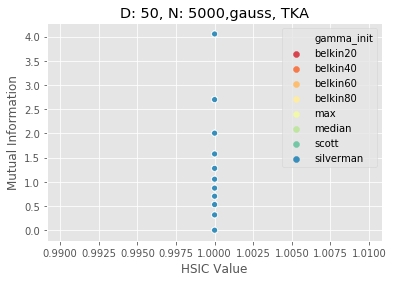

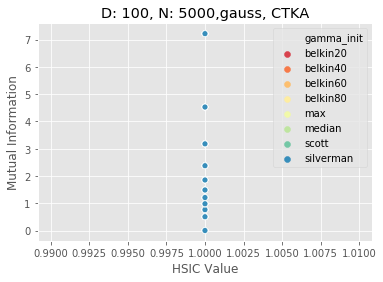

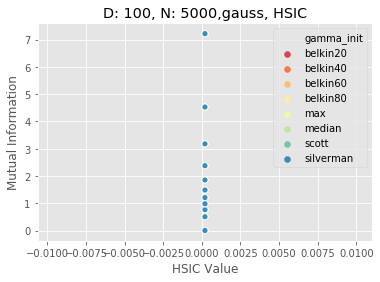

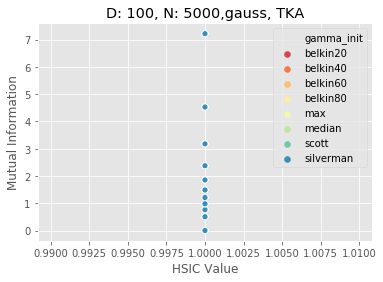

In [11]:
plot_groups = ['dataset', 'n_samples', 'd_dimensions', ]

subres =  results_gaussian.groupby(plot_groups)

for igroup in subres:
    
    
    igroup, fixed_vars = plot_prepare(igroup[1])
    
    t = igroup
#     print(t.head())
    plot_gammas(igroup, fixed_vars, save=True)
#     break


## Figure I - T-Student Distribution

This first figure is to demonstrate how the mutual information compares with the amount of noise for each of the functions **Linear**, **Sinusoidal**, **Circular**, and **Random**.

In [196]:
results_gaussian = results_df[results_df['dataset'] == 'gauss']
results_tstudent = results_df[results_df['dataset'] == 'tstudent']


results_tstudent.head()

,dataset,trial,n_samples,d_dimensions,nu,std,gamma,gamma_init,scorer,value,mi_score
33000,tstudent,1,50,2,1.0,NaN,4.263675,max,hsic,0.019269,0.302042
33001,tstudent,1,50,2,1.0,NaN,4.263675,max,tka,0.763056,0.302042
33002,tstudent,1,50,2,1.0,NaN,4.263675,max,ctka,0.757782,0.302042
33003,tstudent,1,50,2,2.0,NaN,2.444370,max,hsic,0.018497,0.136519
33004,tstudent,1,50,2,2.0,NaN,2.444370,max,tka,0.548196,0.136519


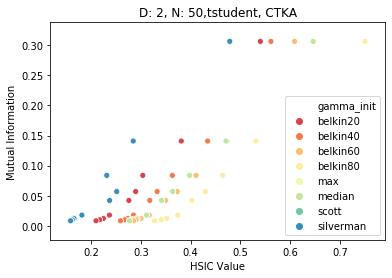

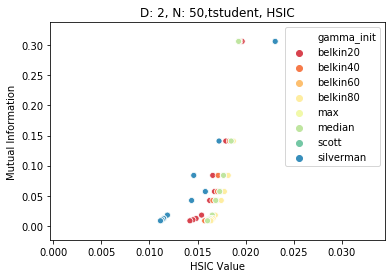

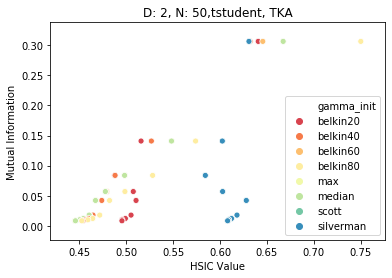

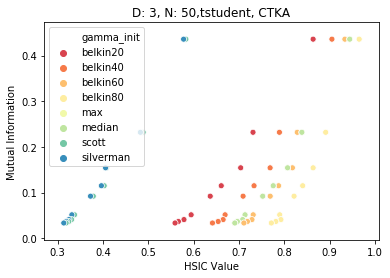

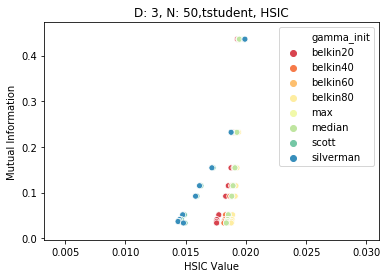

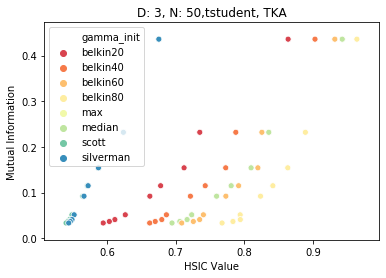

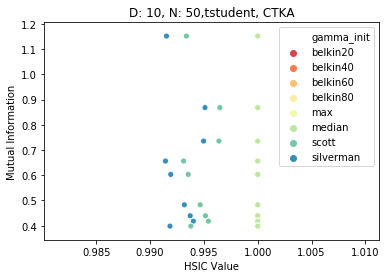

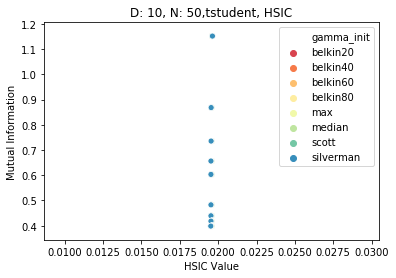

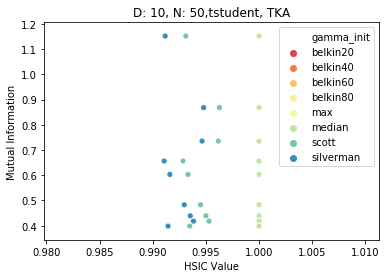

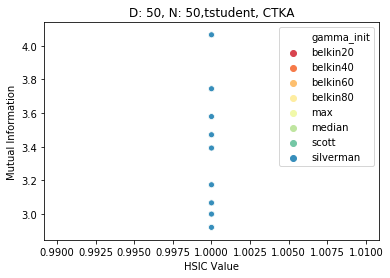

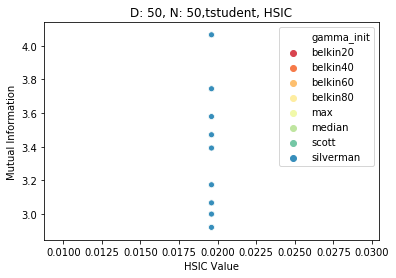

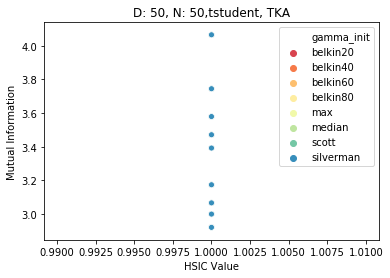

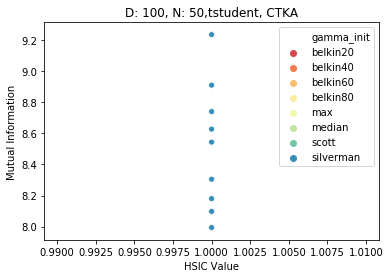

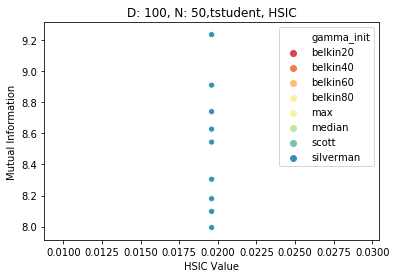

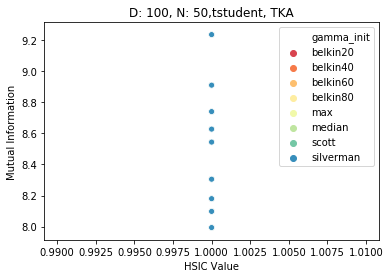

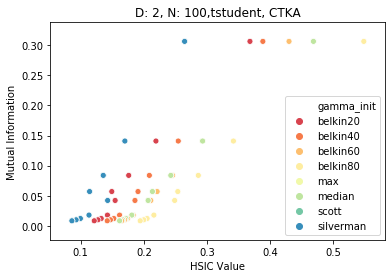

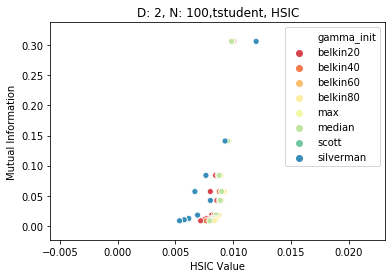

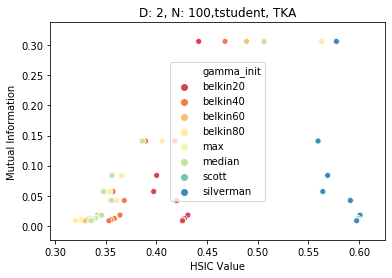

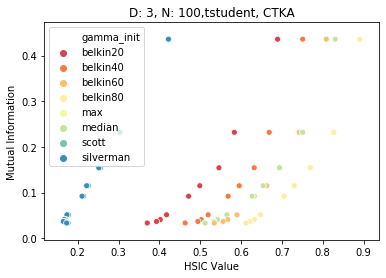

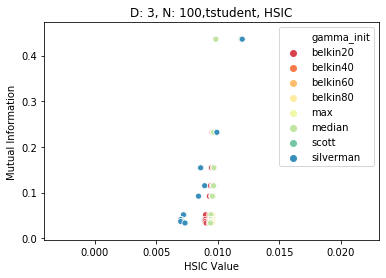

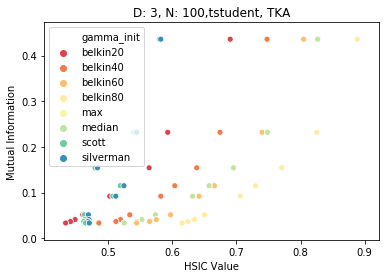

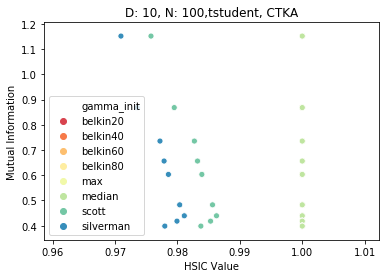

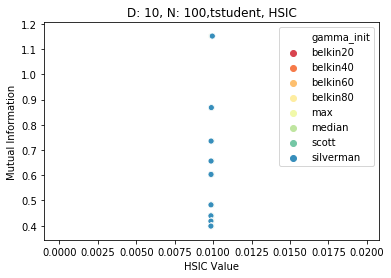

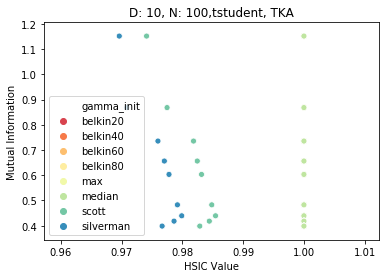

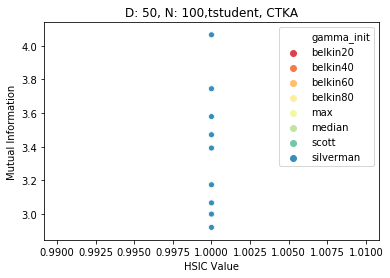

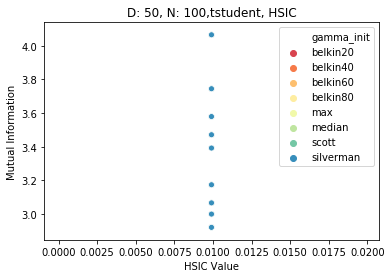

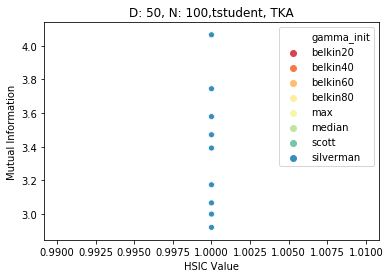

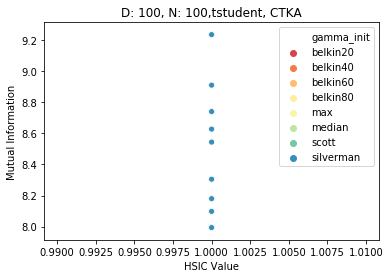

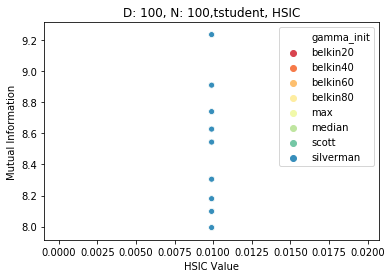

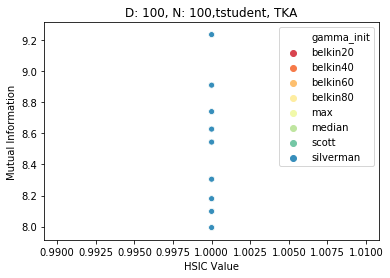

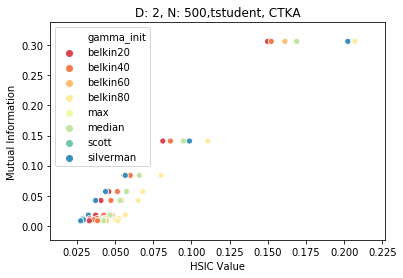

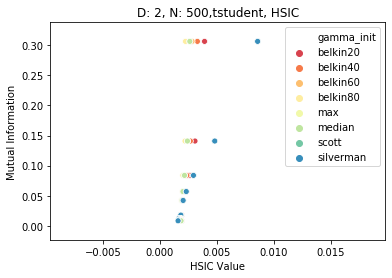

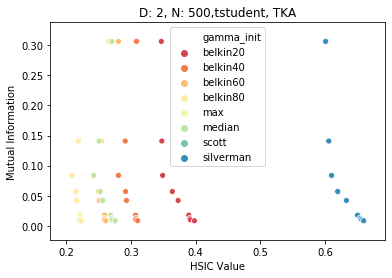

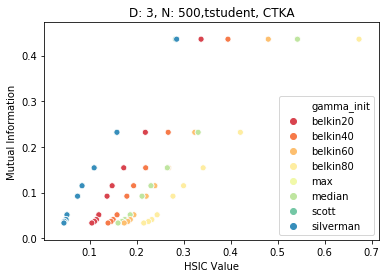

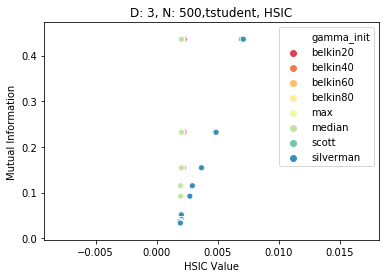

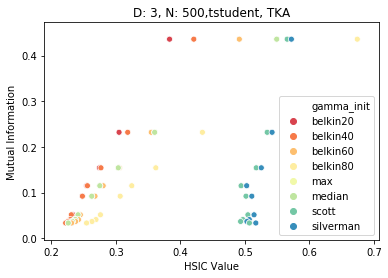

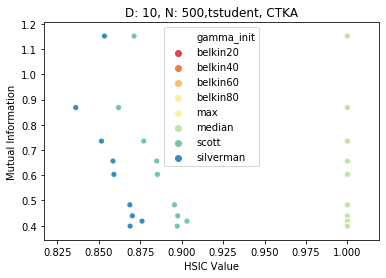

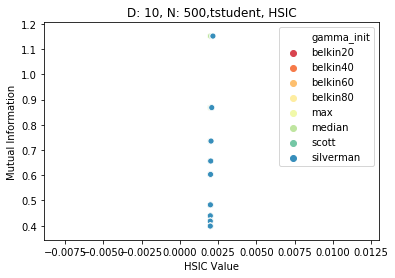

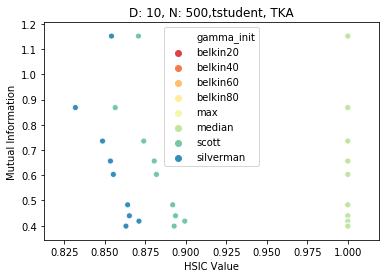

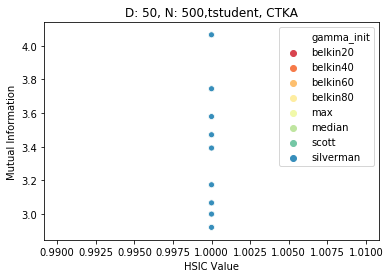

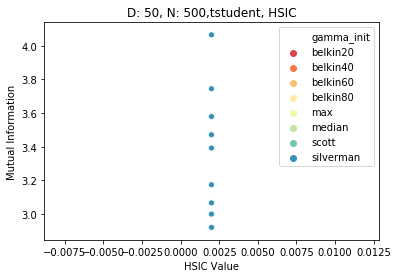

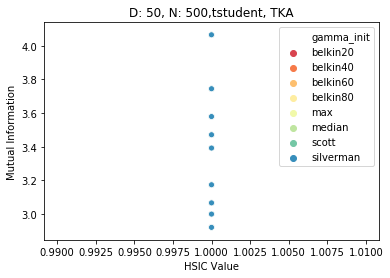

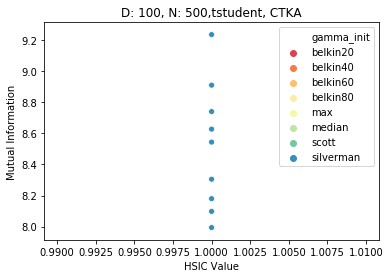

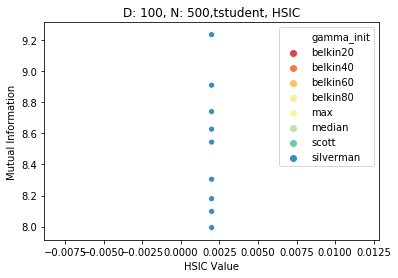

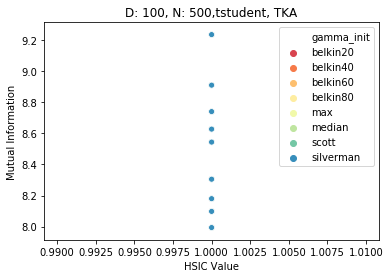

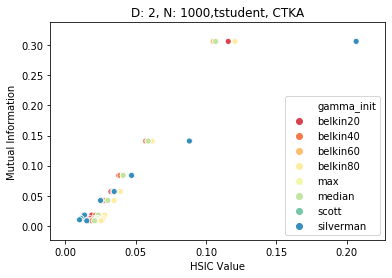

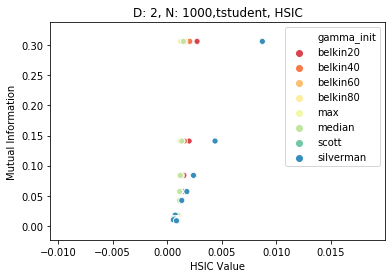

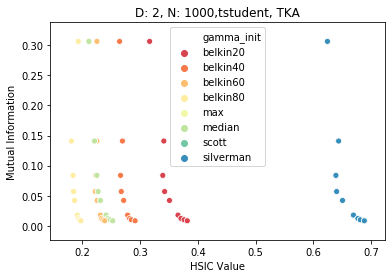

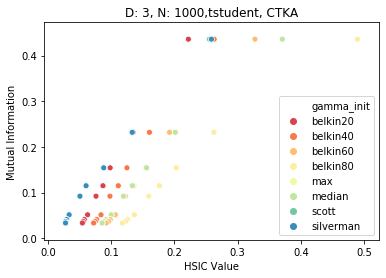

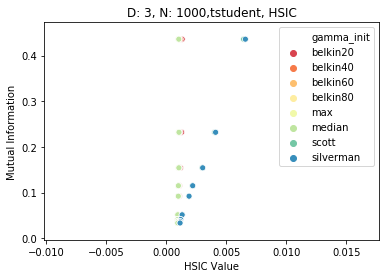

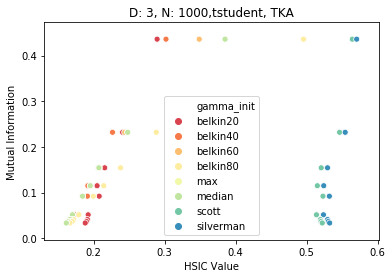

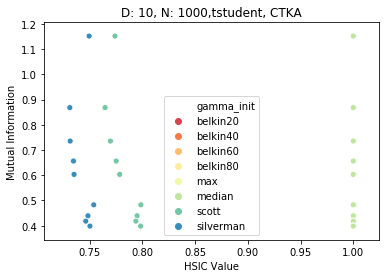

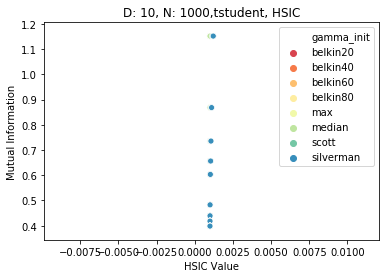

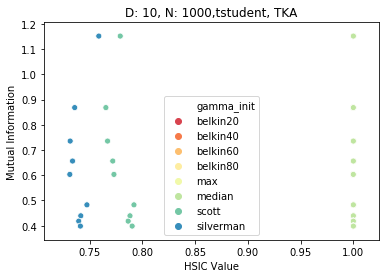

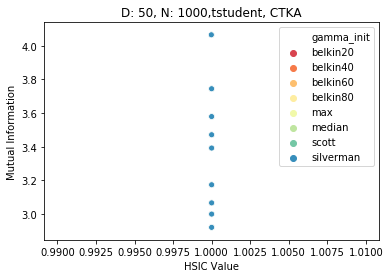

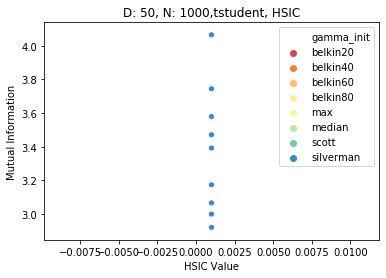

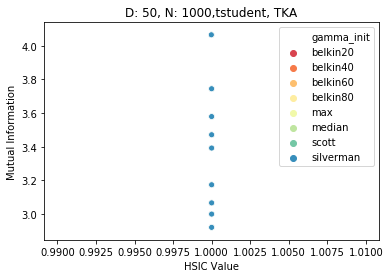

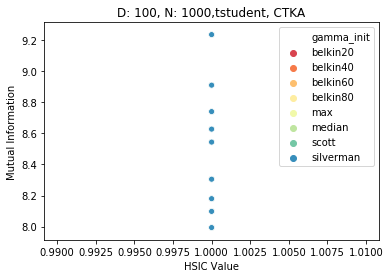

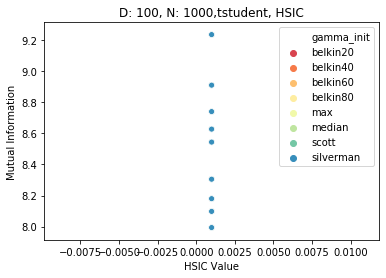

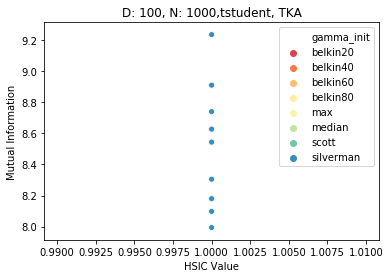

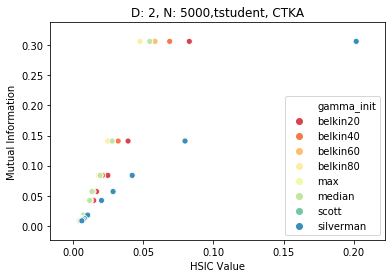

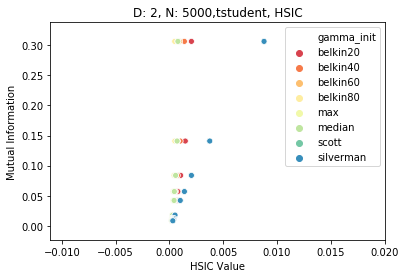

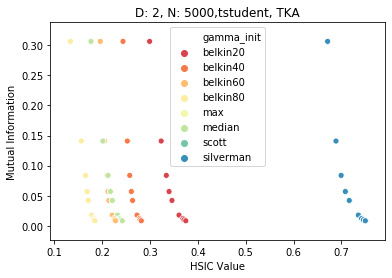

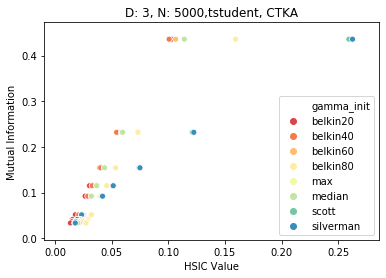

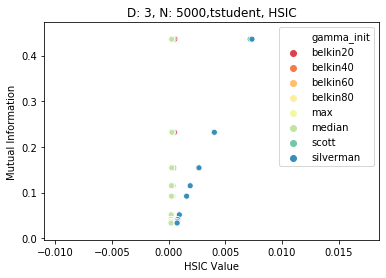

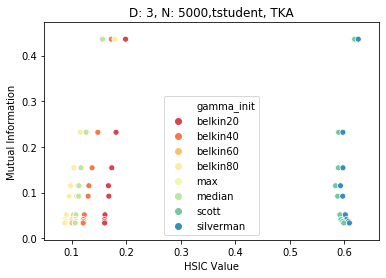

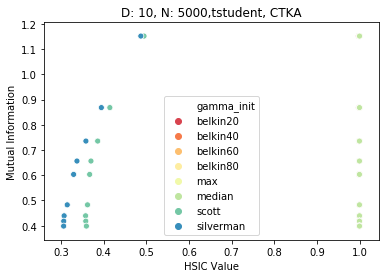

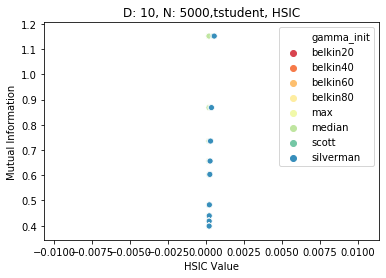

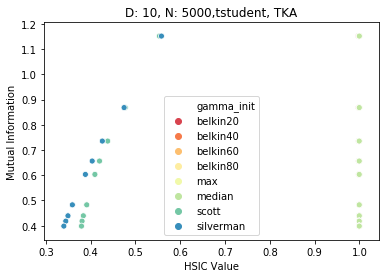

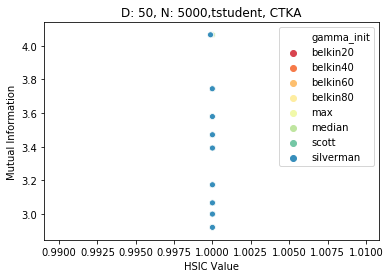

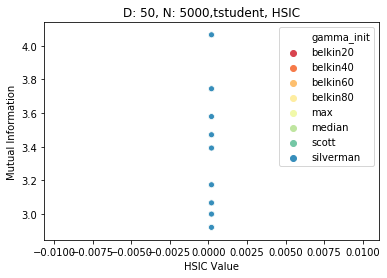

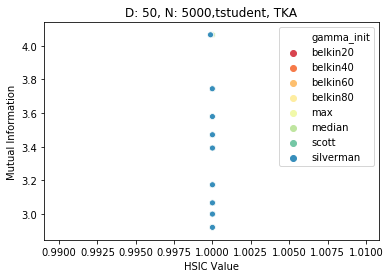

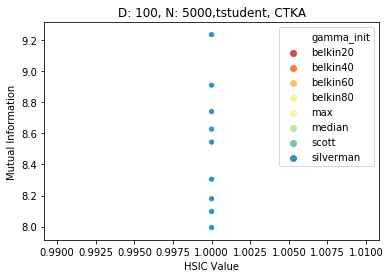

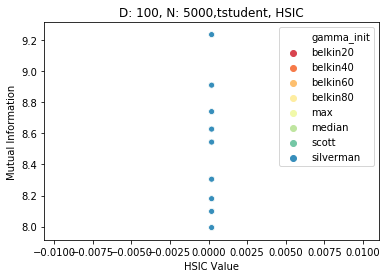

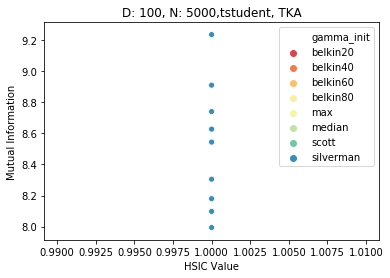

In [198]:
plot_groups = ['dataset', 'n_samples', 'd_dimensions', ]

subres =  results_tstudent.groupby(plot_groups)

for igroup in subres:
    
    
    igroup, fixed_vars = plot_prepare(igroup[1])
    
    t = igroup

    plot_gammas(igroup, fixed_vars, save=True)


In [199]:
def plot_prepare_all(res_df, dataset='gauss'):
    
    # grab dataset attributes (fixed variables)
    dataset = res_df['dataset'].unique()  
    gamma_init = res_df['gamma_init'].unique()
    scorers = res_df['scorer'].unique().tolist()
    fixed_vars = {
        'gamma_init': gamma_init,
        'dataset': dataset,
        'scorer': scorers,
    }

    return res_df, fixed_vars

In [208]:
def plot_all(res_df, fixed_vars, save=True, drop=None, subset=None):
    for iscore in res_df.groupby('scorer'):
        
#         print(iscore[1].head())

        # Drop unnecessary columns
        mean_results = iscore[1].groupby(['mi_score', 'gamma_init']).median()
        std_results = iscore[1].groupby(['mi_score', 'gamma_init']).std()
#         print(mean_results.head(3))
        mean_results = mean_results.reset_index().drop(columns=[ 'trial', 'n_samples', 'd_dimensions', 'nu', 'std'])
        gamma_legend = mean_results['gamma_init'].unique()
        
        # Transform the mi_scores
        mean_results['mi_score'] += 1 #np.log2(mean_results['mi_score']+1)
        if subset is not None:
            mean_results = mean_results[mean_results['gamma_init'].isin(subset)]
        if drop is not None:
            mean_results = mean_results[~mean_results['gamma_init'].isin(drop)]
#         print(mean_results.head(3))
        
#         print(mean_results.head(3))
#         break
#         print(mean_results.head())
        fig, ax = plt.subplots()
        pts = sns.scatterplot(
            x='value', 
            y='mi_score', 
            hue='gamma_init',
            data=mean_results, 
#             size='hsic_std',
#             sizes=(50,200),
            legend='brief',
            ax=ax, 
#             hue='gamma', 
#             hue_norm=matplotlib.colors.LogNorm(),
#             label=iscore[0].upper(),
            palette='Spectral'
        )
#         ax.legend(gamma_legend)
        ax.set_yscale('log')
        ax.set_xlabel('Score')
        ax.set_ylabel(r'Mutual Information')
        ax.set_title(
            f"{fixed_vars['dataset'][0]}, "
            f"{iscore[0].upper()}"
        )
        
        # COLORBAR
#         norm = matplotlib.colors.LogNorm(mean_results.gamma.min(), mean_results.gamma.max())
#         sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
#         sm.set_array([])
#         pts.figure.colorbar(sm, label=r'RBF Bandwidth, $\gamma$')
        
        plt.show()
        if save:
            save_name = \
                f"{fixed_vars['dataset'][0]}_" + \
                f"{iscore[0].upper()}" + \
                ".png"

            fig.savefig(fig_path + save_name)
    return None

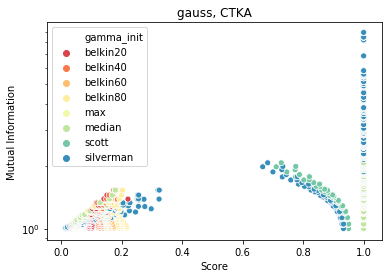

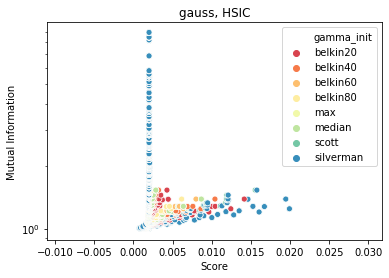

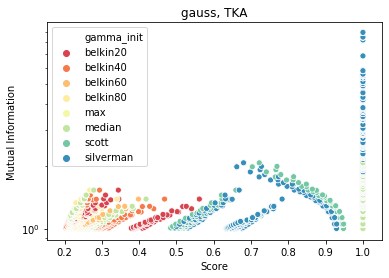

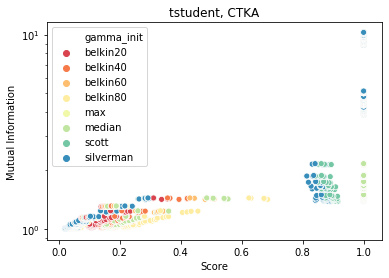

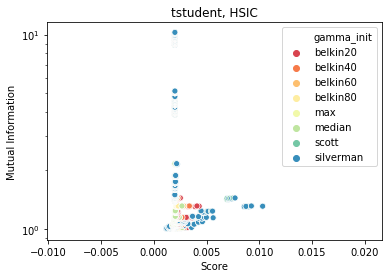

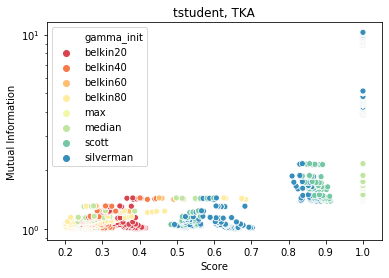

In [214]:
plot_groups = ['dataset', ]

subres =  results_df.groupby(plot_groups)

for igroup in subres:
    
    
    igroup, fixed_vars = plot_prepare_all(igroup[1])
    
    t = igroup
    plot_all(igroup, fixed_vars, save=False, drop=None, subset=None)
#     break